# Deep Learning for Bot detection

### Author: Javier Pérez Clemente

libraries

In [22]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Data types

In [23]:
user_dtypes = {
    'id': object , 
    'utc_offset': object
}

tweets_dtypes = {
    'id': object, 
    'user_id': object,
    'in_reply_to_status_id': object,
    'in_reply_to_user_id': object,
    'retweeted_status_id': object,
    'geo': object
}

friends_dtypes = {
    'source_id': object, 
    'target_id': object
}

followers_dtypes = {
    'source_id': object, 
    'target_id': object
}

user_columns = ['bot', 'created_at', 'default_profile', 'default_profile_image', 'description', 'favourites_count', 'followers_count', 'friends_count', 'geo_enabled', 'id', 'lang', 'listed_count', 'location', 'name', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_banner_url', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'protected', 'screen_name', 'statuses_count', 'time_zone', 'updated', 'url', 'utc_offset', 'verified']

### cresci-2015

In [24]:
root_dir = './data/cresci-2015.csv/'
dirs = sorted(os.listdir(root_dir))

df_users_2015 = pd.DataFrame()
df_tweets_2015 = pd.DataFrame()
df_friends_2015 = pd.DataFrame()
df_followers_2015 = pd.DataFrame()

for item in dirs:
    if os.path.isdir(root_dir + item):
        with open(root_dir + item + '/users.csv', 'rb') as users_file:
            is_bot = 1 if item in ['INT.csv', 'FSF.csv', 'TWT.csv'] else 0
            new_users = pd.read_csv(users_file, dtype = user_dtypes)
            new_users['bot'] = is_bot
            df_users_2015 = pd.concat([df_users_2015, new_users])
            
#         with open(root_dir + item + '/tweets.csv', 'rb') as tweets_file:
#             df_tweets_2015 = pd.concat([df_tweets_2015, pd.read_csv(tweets_file, dtype = tweets_dtypes)])
            
#         with open(root_dir + item + '/friends.csv', 'rb') as friends_file:
#             df_friends_2015 = pd.concat([df_friends_2015, pd.read_csv(friends_file, dtype = friends_dtypes)])
            
#         with open(root_dir + item + '/followers.csv', 'rb') as followers_file:
#             df_followers_2015 = pd.concat([df_followers_2015, pd.read_csv(followers_file, dtype = followers_dtypes)])
df_users_2015 = df_users_2015.loc[:, user_columns]

### cresci-2017

In [25]:
root_dir = './data/cresci-2017.csv/datasets_full.csv/'
dirs = [item for item in sorted(os.listdir(root_dir)) if 'crowdflower_results' not in item]

df_users_2017 = pd.DataFrame()
df_tweets_2017 = pd.DataFrame()
df_friends_2017 = pd.DataFrame()
df_followers_2017 = pd.DataFrame()

for item in dirs:
    if os.path.isdir(root_dir + item):
        with open(root_dir + item + '/users.csv', 'rb') as users_file:
            is_bot = 1 if 'genuine' not in item else 0
            new_users = pd.read_csv(users_file, dtype = user_dtypes)
            new_users['bot'] = is_bot
            df_users_2017 = pd.concat([df_users_2017, new_users], sort=True)
            
#         with open(root_dir + item + '/tweets.csv', 'rb') as tweets_file:
#             df_tweets = pd.concat([df_tweets, pd.read_csv(tweets_file, dtype = tweets_dtypes)])
            
#         with open(root_dir + item + '/friends.csv', 'rb') as friends_file:
#             df_friends = pd.concat([df_friends, pd.read_csv(friends_file, dtype = friends_dtypes)])
            
#         with open(root_dir + item + '/followers.csv', 'rb') as followers_file:
#             df_followers = pd.concat([df_followers, pd.read_csv(followers_file, dtype = followers_dtypes)])

df_users_2017 = df_users_2017.loc[:, user_columns]

In [26]:
df_users = pd.concat([df_users_2015, df_users_2017])

## Exploratory Data Analysis

|VARIABLE|STATUS|
|:--|:-------------------|
|id|Not usefull. Dropped|
|name|Not usefull. Dropped|
|screen_name|Not usefull. Dropped|
|statuses_coun|np.int64|
|followers_count|np.int64|
|friends_count|np.int64|
|favourites_count|np.int64|
|listed_count|np.int64|
|created_at|Not usefull. Dropped|
|url|Converted to binary|
|lang|Not usefull. Dropped|
|time_zone|Not usefull. Dropped|
|location|Not usefull. Dropped|
|default_profile|Binary NaNs to 0|
|default_profile_image|Binary NaNs to 0|
|geo_enabled|Binary NaNs to 0|
|profile_image_url|Not usefull. Dropped. Impossible to convert to binary since there are no NaNs					 |
|profile_banner_url|Binary NaNs to 0|
|profile_use_background_image|Binary NaNs to 0|
|profile_background_image_url_https|Repeated. Dropped|
|profile_text_color|Not sure what to do. Likely to be dropped|
|profile_image_url_https|Repeated. Dropped|
|profile_sidebar_border_color|Not sure what to do. Likely to be dropped|
|profile_background_tile|Binary NaNs to 0|
|profile_sidebar_fill_color|Not sure what to do. Likely to be dropped|
|profile_background_image_url|Not usefull. Dropped. Impossible to convert to binary since there are no NaNs|
|profile_background_color|Not sure what to do. Likely to be dropped|
|profile_link_color|Not sure what to do. Likely to be dropped|
|utc_offset|Not usefull. Dropped|
|protected|Not usefull. Dropped. Impossible to convert to binary since there are only NaNs|
|verified|Not usefull. Dropped. Impossible to convert to binary since there are only NaNs|
|description|Converted to bins of length(description). Most of the rows with length(description) < 5 are bots|
|updated|Not usefull. Dropped|
|dataset|Not usefull. Dropped|
|bot|label|

In [27]:
def amend_binary(df, var):
    df[var] = pd.to_numeric(df[var]).fillna(0).map(np.int64)
    return df

def to_dummie(df, var):
    var_dummies = pd.get_dummies(df.loc[:, var])
    print(var_dummies.shape)
    df.drop(var, axis=1, inplace=True)
    df = pd.concat([df, var_dummies], axis=1)
    return df

def to_dummies(df, variables):
    for var in variables:
        df = to_dummie(df, var)
    return df

def to_binary(df, var):
    df[var] = np.where(df[var].isnull(), 0, 1)
    return df

def to_binaries(df, variables):
    for var in variables:
        df = to_binary(df, var)
    return df

user_binary_vars = ['geo_enabled', 'profile_use_background_image', 'default_profile', 'default_profile_image', 'profile_background_tile', 'protected', 'verified']
for var in user_binary_vars:
            df_users = amend_binary(df_users, var)
    
# tweet_binary_vars = ['truncated']
# for var in tweet_binary_vars:
#     df_tweets = to_binary(df_tweets, var)

# Variables convertidas a binarias.
to_binary_vars = ['url', 'profile_image_url', 'profile_banner_url', 'profile_background_image_url']
df_users = to_binaries(df_users, to_binary_vars)

# Variables dummies. Estas variables de momento no entran en el modelo.
# df_users = to_dummies(df_users, ['lang', 'time_zone']) 

# Variables a eliminar
vars_to_drop = ['id','screen_name', 'name','created_at', 'location', 'lang', 'time_zone', 'profile_text_color', 'profile_sidebar_border_color','profile_image_url_https', 'profile_image_url', 'profile_background_image_url_https', 'protected', 'verified', 'updated', 'utc_offset', 'profile_sidebar_fill_color', 'profile_background_color', 'profile_link_color', 'profile_background_image_url']

In [28]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19669 entries, 0 to 1127
Data columns (total 34 columns):
bot                                   19669 non-null int64
created_at                            19669 non-null object
default_profile                       19669 non-null int64
default_profile_image                 19669 non-null int64
description                           12709 non-null object
favourites_count                      19669 non-null int64
followers_count                       19669 non-null int64
friends_count                         19669 non-null int64
geo_enabled                           19669 non-null int64
id                                    19669 non-null object
lang                                  18669 non-null object
listed_count                          19669 non-null int64
location                              11773 non-null object
name                                  19668 non-null object
profile_background_color              18669 non-null object


In [29]:
bots = df_users.loc[df_users['bot'] == 1]
humans = df_users.loc[df_users['bot'] == 0]

print(bots.shape[0]/df_users.shape[0])

print(humans.shape[0]/df_users.shape[0])

0.7242361075804565
0.27576389241954347


### Variable "statuses_count"

Text(0, 0.5, 'count')

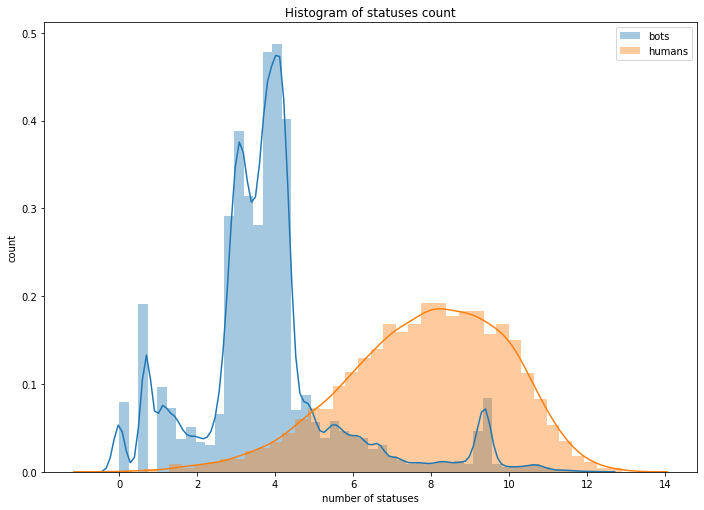

In [30]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

bots = df_users.loc[df_users['bot'] == 1]
humans = df_users.loc[df_users['bot'] == 0]
sns.distplot(np.log(bots.loc[:,'statuses_count'] + 1), label='bots')
sns.distplot(np.log(humans.loc[:,'statuses_count'] + 1), label='humans')

plt.legend()
plt.title('Histogram of statuses count')
plt.xlabel('number of statuses')
plt.ylabel('count')

### Variable "followers_count"

Text(0, 0.5, 'count')

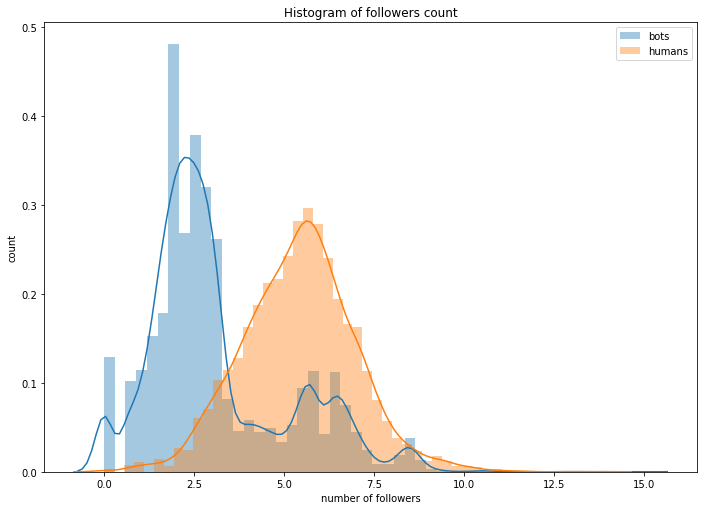

In [31]:
fig, ax = plt.subplots(figsize=a4_dims)

sns.distplot(np.log(bots.loc[:,'followers_count'] + 1), label='bots')
sns.distplot(np.log(humans.loc[:,'followers_count'] + 1), label='humans')

plt.legend()
plt.title('Histogram of followers count')
plt.xlabel('number of followers')
plt.ylabel('count')

### Variable "friends_count"

Text(0, 0.5, 'log(count)')

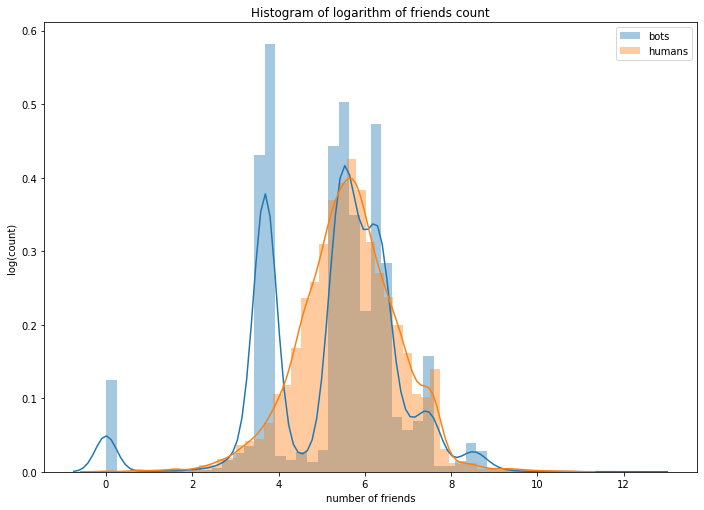

In [32]:
fig, ax = plt.subplots(figsize=a4_dims)

sns.distplot(np.log(bots.loc[:, 'friends_count'] + 1), label='bots')
sns.distplot(np.log(humans.loc[:, 'friends_count'] + 1), label='humans')

plt.legend()
plt.title('Histogram of logarithm of friends count')
plt.xlabel('number of friends')
plt.ylabel('log(count)')

### Variable "favourites_count"

Text(0, 0.5, 'count')

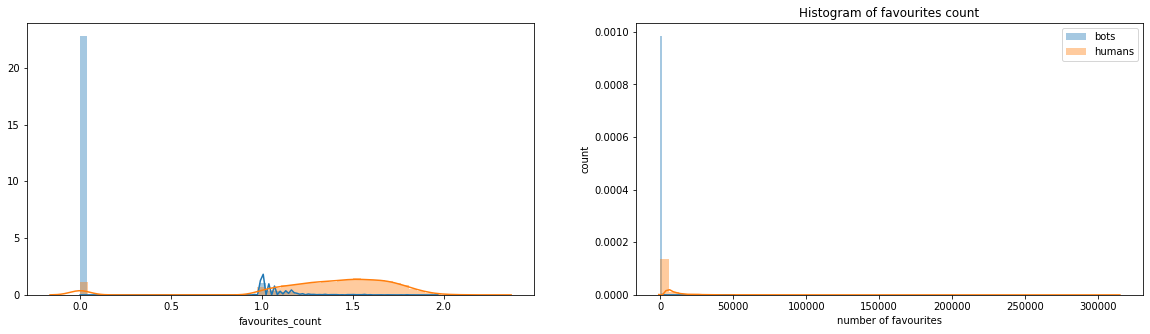

In [33]:
fig, ax = plt.subplots(1, 2, figsize=[20, 5])

sns.distplot(np.power(bots.loc[:,'favourites_count'], 1/16), ax=ax[0], label='bots')
sns.distplot(np.power(humans.loc[:,'favourites_count'], 1/16), ax=ax[0], label='humans')

sns.distplot(bots.loc[:,'favourites_count'], ax=ax[1], label='bots')
sns.distplot(humans.loc[:,'favourites_count'], ax=ax[1], label='humans')

plt.legend()
plt.title('Histogram of favourites count')
plt.xlabel('number of favourites')
plt.ylabel('count')

### Variable "listed_count"

Text(0, 0.5, 'count')

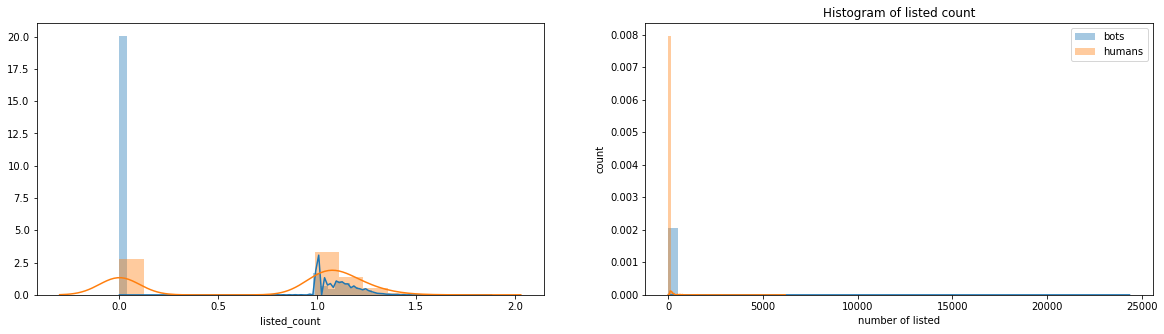

In [34]:
fig, ax = plt.subplots(1, 2, figsize=[20, 5])

sns.distplot(np.power(bots.loc[:,'listed_count'], 1/16), ax=ax[0], label='bots', norm_hist = True)
sns.distplot(np.power(humans.loc[:,'listed_count'], 1/16), ax=ax[0], label='humans', norm_hist = True)

sns.distplot(bots.loc[:,'listed_count'], ax=ax[1], label='bots', norm_hist = True)
sns.distplot(humans.loc[:,'listed_count'], ax=ax[1], label='humans', norm_hist = True)

plt.legend()
plt.title('Histogram of listed count')
plt.xlabel('number of listed')
plt.ylabel('count')

### Transformations

In [35]:
log_vars = ['friends_count', 'followers_count', 'statuses_count']
for var in log_vars:
    var_new_name = 'log_' + var
    df_users[var_new_name] = np.log(df_users[var] + 1)

root_vars = ['listed_count', 'favourites_count']   
for var in root_vars:
    var_new_name = '16rt_' + var
    df_users[var_new_name] = np.power(df_users[var], 1/16)

vars_to_drop = vars_to_drop + log_vars + root_vars

bot                                     int64
created_at                             object
default_profile                         int64
default_profile_image                   int64
description                            object
favourites_count                        int64
followers_count                         int64
friends_count                           int64
geo_enabled                             int64
id                                     object
lang                                   object
listed_count                            int64
location                               object
name                                   object
profile_background_color               object
profile_background_image_url            int64
profile_background_image_url_https     object
profile_background_tile                 int64
profile_banner_url                      int64
profile_image_url                       int64
profile_image_url_https                object
profile_link_color                

### Variable "description"

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Histogram of Arrival Delays')

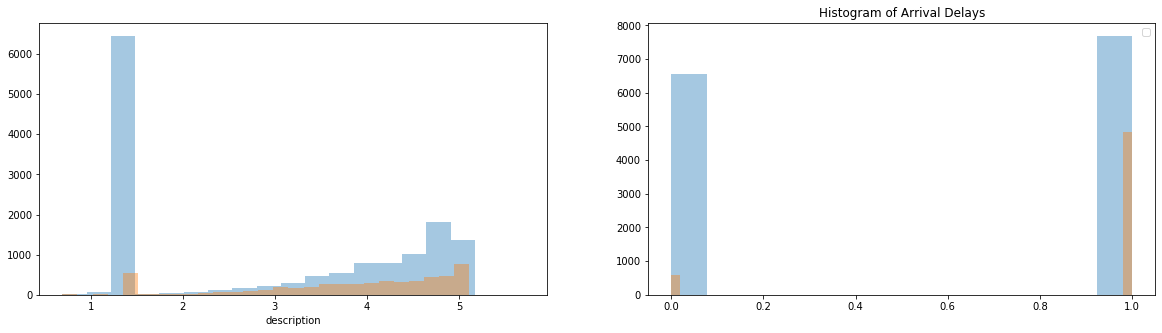

In [43]:
fig, ax = plt.subplots(1, 2, figsize=[20, 5])

sns.distplot(np.log(bots.loc[:,'description'].map(lambda x: len(str(x))) + 1), ax=ax[0], kde=False)
sns.distplot(np.log(humans.loc[:,'description'].map(lambda x: len(str(x))) + 1), ax=ax[0], kde=False)

sns.distplot(np.where(bots.loc[:,'description'].map(lambda x: len(str(x))) > 5, 1, 0), ax=ax[1], kde=False)
sns.distplot(np.where(humans.loc[:,'description'].map(lambda x: len(str(x))) > 5, 1, 0), ax=ax[1], kde=False)


plt.legend()
plt.title('Histogram of Arrival Delays')

In [41]:
df_users.loc[:,'descr_longr_5'] = np.where(df_users.loc[:,'description'].map(lambda x: len(str(x))) > 5, 1, 0)

vars_to_drop.append('description')

Drop unnecessary variables

In [42]:
df_users.drop(vars_to_drop, axis=1, inplace=True)
df_users.dtypes

bot                               int64
default_profile                   int64
default_profile_image             int64
geo_enabled                       int64
profile_background_tile           int64
profile_banner_url                int64
profile_use_background_image      int64
url                               int64
log_friends_count               float64
log_followers_count             float64
log_statuses_count              float64
16rt_listed_count               float64
16rt_favourites_count           float64
descr_longr_5                     int64
dtype: object

### Corretlations

bot ['16rt_favourites_count']
default_profile []
default_profile_image []
geo_enabled []
profile_background_tile []
profile_banner_url []
profile_use_background_image []
url []
log_friends_count []
log_followers_count []
log_statuses_count []
16rt_listed_count []
16rt_favourites_count ['bot']
descr_longr_5 []


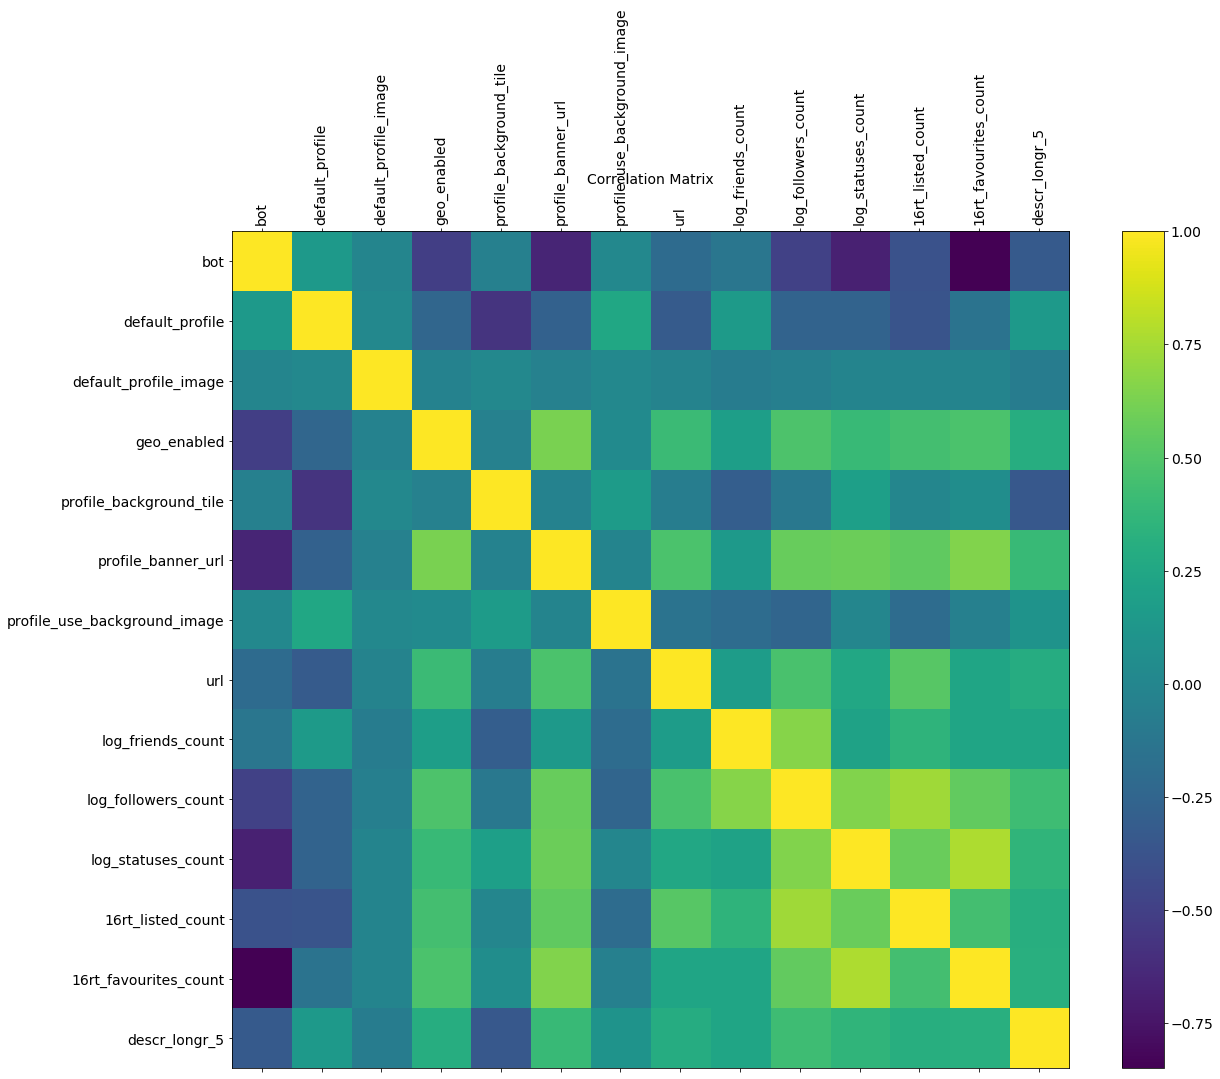

In [44]:
df = df_users

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=14);

col_names = df.corr().columns.values

for col, row in ((df.corr().abs() > 0.8) & (df.corr().abs() < 1)).iteritems():
    print(col, col_names[row.values])

In [45]:
corr_matrix = df_users.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

[column for column in upper.columns if any(upper[column] > 0.80)]

['16rt_favourites_count']

La variable 16rt_favourites_count presenta una correlación mayor del 80% con la variable de salida. Esto nos indica que será importante en el modelo.

## Training and testing division

In [46]:
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

y = df_users.loc[:, 'bot']
X = df_users.loc[:, df_users.columns != 'bot']

X_train, X_remain, y_train, y_remain \
    = train_test_split(X, y, train_size=0.8)

X_test, X_val, y_test, y_val \
    = train_test_split(X_remain, y_remain, test_size=0.5)

In [55]:
print('dataset size: ' + str(df_users.shape[0]) + ' rows and '+ str(df_users.shape[1]) + ' variables.')
print('training size: ' + str(X_train.shape[0]) + ' rows and '+ str(X_train.shape[1]) + ' variables.')
print('testing size: ' + str(X_test.shape[0]) + ' rows and '+ str(X_test.shape[1]) + ' variables.')
print('validation size: ' + str(X_val.shape[0]) + ' rows and '+ str(X_val.shape[1]) + ' variables.')

dataset size: 19669 rows and 14 variables.
training size: 15735 rows and 13 variables.
testing size: 1967 rows and 13 variables.
validation size: 1967 rows and 13 variables.


## Model implementation

In [56]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import keras

epochs = 10
batch_size = 5

Using TensorFlow backend.


In [57]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

# evaluate model with standardized dataset
model = create_baseline()

model.summary()

plot_model(model, to_file='model.png')

W0806 11:14:32.211966 139919365273408 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 11:14:32.237938 139919365273408 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 11:14:32.239964 139919365273408 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0806 11:14:32.286880 139919365273408 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


Mean estimated accuracy and standard deviation (average spread)

In [58]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results_train = cross_val_score(estimator, X_train, y_train, cv=kfold)

print("Train Results: %.2f%% (%.2f%%)" % (results_train.mean()*100, results_train.std()*100))

W0806 11:14:39.192040 139919365273408 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train Results: 96.72% (0.43%)


In [59]:
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
15735/15735 [==============================] - 23s 1ms/step - loss: 0.2640 - acc: 0.9040
Epoch 2/10
15735/15735 [==============================] - 22s 1ms/step - loss: 0.1478 - acc: 0.9607
Epoch 3/10
15735/15735 [==============================] - 23s 1ms/step - loss: 0.1219 - acc: 0.9635
Epoch 4/10
15735/15735 [==============================] - 27s 2ms/step - loss: 0.1148 - acc: 0.9643
Epoch 5/10
15735/15735 [==============================] - 27s 2ms/step - loss: 0.1100 - acc: 0.9649
Epoch 6/10
15735/15735 [==============================] - 24s 2ms/step - loss: 0.1070 - acc: 0.9659
Epoch 7/10
15735/15735 [==============================] - 25s 2ms/step - loss: 0.1055 - acc: 0.9667
Epoch 8/10
15735/15735 [==============================] - 24s 2ms/step - loss: 0.1033 - acc: 0.9661
Epoch 9/10
15735/15735 [==============================] - 24s 2ms/step - loss: 0.1004 - acc: 0.9671
Epoch 10/10
15735/15735 [==============================] - 25s 2ms/step - loss: 0.0958 - acc: 0.9680

In [60]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.09114526057095614
Train accuracy: 0.96904988879812


In [61]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07974189325947414
Test accuracy: 0.9720386375493669


In [62]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.08902636864215484
Validation accuracy: 0.9694966954753431


Test accuracy for 10 k-fold cross validation

In [63]:
y_pred = model.predict_classes(X_test, batch_size=batch_size)
y_pred

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[ 490,   23],
       [  32, 1422]])

In [64]:
accuracy = (tp + tn)/(tp + tn + fp + fn)
precission = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = 2*precission*recall/(precission+recall)

In [65]:
accuracy

0.9720386375190646

In [66]:
precission

0.9840830449826989

In [67]:
recall

0.9779917469050894

In [68]:
f1

0.9810279406691963